# Fitting DLT with Complex Seasonality - Daily Forecast Example

There are some challenges to fit complex seasonality with LGT/DLT. Although one should usually look into some models such as **Kernel-based Time-varying Regression(KTR)** from other section, we demonstrate a work around if one wants explore complex seasonality model with DLT.

## the data

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together in **DLT**. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) and Turkish daily electricity demand data from Rob Hyndman's [post](https://robjhyndman.com/publications/complex-seasonality/)

In [1]:
import pandas as pd
import numpy as np
import ssl 

from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
# to make fourier series for annual seasonality
from orbit.utils.features import make_fourier_series_df
from orbit.utils.dataset import load_electricity_demand, load_m5daily
from orbit.utils.params_tuning import generate_param_args_list

%load_ext autoreload
%autoreload 2

## the methodology

Here user can leverage Fourier terms as regressors to handle extra layers of seasonality while using **DLT** seasonality argument for the first layer (the one with the shortest cycle). This type of regression is also referred to **harmonic regression** by Young, Pedregal & Tych(1999).

## Example I - M5 Aggregated Sales

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [2]:
df = load_m5daily()
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]

Users can use the `make_fourier_series_df` to create Fourier terms. A `log` and division by first observation also used as pre-processing to make a better fit.

In [3]:
df, fs_cols = make_fourier_series_df(df, period=365.25, order=3)
# trim data with useful columns only
df = df[["date", "sales"] + fs_cols + regressor_col]
m = df['sales'][0]
df['y'] = np.log(df['sales']/m)

In [4]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

In [5]:
train_df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,y
0,2011-01-29,32631,0.999852,0.017202,0.999408,0.034398,0.998669,0.051584,0,0,0,0,0,0,0,0.000000
1,2011-01-30,31749,0.999408,0.034398,0.997634,0.068755,0.994678,0.103031,0,0,0,0,0,0,0,-0.027402
2,2011-01-31,23783,0.998669,0.051584,0.994678,0.103031,0.988039,0.154204,0,0,0,0,0,0,0,-0.316292
3,2011-02-01,25412,0.997634,0.068755,0.990545,0.137185,0.978769,0.204966,0,0,0,0,0,0,0,-0.250041
4,2011-02-02,19146,0.996303,0.085906,0.985240,0.171177,0.966893,0.255182,0,0,0,0,0,0,0,-0.533169


initialize and train the model.

In [6]:
%%time
dlt = DLT(
    response_col='y',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols + regressor_col,
    estimator='stan-mcmc',
)
dlt.fit(train_df)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.000, warmups(per chain):225 and samples(per chain):25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 452 ms, sys: 282 ms, total: 734 ms
Wall time: 58 s


predict and plot the result.

In [6]:
pred_df = dlt.predict(test_df)
# reverse transformation for prediction
pred_df[['prediction_5', 'prediction', 'prediction_95']] = \
  pred_df[['prediction_5', 'prediction', 'prediction_95']].apply(np.exp) * m
# plot last 300 observations from train only
plot_predicted_data(train_df[-300:], pred_df, 'date', 'sales', 'prediction', test_actual_df=test_df);

NameError: name 'dlt' is not defined

## Example II - Turkish Daily Electricity

Another example is the Turkish daily electricity demand data posted by Rob Hyndman. In this case, the seasonality is relatively smooth compared to the previous dataset.

In [7]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()
date_col = 'date'
response_col = 'electricity'
m = df['electricity'][0]
df[response_col] = np.log(df[response_col] / m)
print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,0.000000
1,2000-01-02,0.063700
2,2000-01-03,0.198053
3,2000-01-04,0.216324
4,2000-01-05,0.223295


In [8]:
df, fs_cols = make_fourier_series_df(df, 365.25, order=3)

In [9]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

Note that due to the smoothness of the true seasonality (and with a long duration of a cycle), this hits the limit of **DLT** where it uses 1-step-ahead loss to guide the fitness. In breif, the smoothness nature of the seasonality  introduces some [degeneracy](https://en.wikipedia.org/wiki/Degeneracy_(mathematics)) issues where the model finds making a relatively memoryless trend can mimic a "good" 1-step ahead forecast.  

To resolve this issue, one can leverage the arg `forecast_horizon` to generate useful **Bayesian Information Criteria (BIC)** statistics to guide a better long-term forecast model. One can simply match the usage of the model with an appropriate value of `forecast_horizon`. For example, a `90` value is reasonable if we use it for quarterly forecast. The plan is to compute BIC on different setting of the smoothing parameters input by using args such as `level_sm_input`, `slope_sm_input` and `seasonality_sm_input`.

Another way to solve the problem is to leverage the hyper-parameters tuning function provided by the package (see the section discussing `Backtester` and `grid_search`).

First, users can propose a few choices as a grid.

In [15]:
param_grid = {
    'level_sm_input': [1e-3, 1e-2, 1e-1, 0.5],
    'slope_sm_input': [1e-3, 1e-2, 1e-1, 0.5],
    'seasonality_sm_input': [1e-3, 0.3],
}

param_args_list = generate_param_args_list(param_grid)
# this saves time for demo purpose only
param_args_list = [x for x in param_args_list if x['level_sm_input'] == x['slope_sm_input']]
len(param_args_list)

8

After that, create a data frame to store the BIC of each setting.

In [16]:
res = pd.DataFrame(param_args_list)
# placeholder
res['bic'] = np.nan
res

,level_sm_input,seasonality_sm_input,slope_sm_input,bic
0,0.001,0.001,0.001,NaN
1,0.001,0.300,0.001,NaN
2,0.010,0.001,0.010,NaN
3,0.010,0.300,0.010,NaN
4,0.100,0.001,0.100,NaN
5,0.100,0.300,0.100,NaN
6,0.500,0.001,0.500,NaN
7,0.500,0.300,0.500,NaN


A simple grid search can be implemented as below. Note: the development is considering a end-to-end util to wrap this process.

In [17]:
from tqdm import tqdm

In [30]:
%%time
for idx in tqdm(range(len(param_args_list))):
    param_args = param_args_list[idx]
    dlt = DLT(
        date_col='date',
        response_col=response_col,
        regressor_col=fs_cols,
        regressor_sigma_prior=[10] * len(fs_cols),
        seasonality=7,
        seed=2022,
        forecast_horizon=365,
        estimator='stan-map',
        **param_args,
    )
    dlt.fit(train_df)
    res.loc[idx, 'bic'] = dlt.get_bic()

 62%|████████████████████████████████████████                        | 5/8 [01:45<01:03, 21.15s/it]INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aec9f19b676e0ecff1bcca082962e24a NOW.
In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:771:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRE

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:781:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long long, 2521

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:781:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:82:16: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

In file included from /var/folders/9f/m35pbwgx13n2j29rjhpkcyg40000gn/T/pystan_lrlxx_71/stanfit4anon_model_aec9f19b676e0ecff1bcca082962e24a_7820841620377127250.cpp:780:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/edwinng/work/venv/orbit37/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Users/edwinng/work/venv/

156 warnings generated.
100%|████████████████████████████████████████████████████████████████| 8/8 [05:02<00:00, 37.83s/it]

CPU times: user 4min 4s, sys: 9.22 s, total: 4min 13s
Wall time: 5min 2s


In [33]:
res = res.sort_values(by='bic')
best_param_args = dict(res.loc[0, ['level_sm_input', 'seasonality_sm_input', 'slope_sm_input']])
best_param_args

{'level_sm_input': 0.001,
 'seasonality_sm_input': 0.001,
 'slope_sm_input': 0.001}

Refit the model with the best (lowest) leave-future out BIC.

In [34]:
%%time
dlt = DLT(
    date_col='date',
    response_col=response_col,
    regressor_col=fs_cols,
    regressor_sigma_prior=[10] * len(fs_cols),
    seasonality=7,
    seed=2022,
    estimator='stan-map',
    **best_param_args,
)
dlt.fit(train_df);

INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


CPU times: user 1.02 s, sys: 60.4 ms, total: 1.08 s
Wall time: 1.09 s


predict and plot the result.

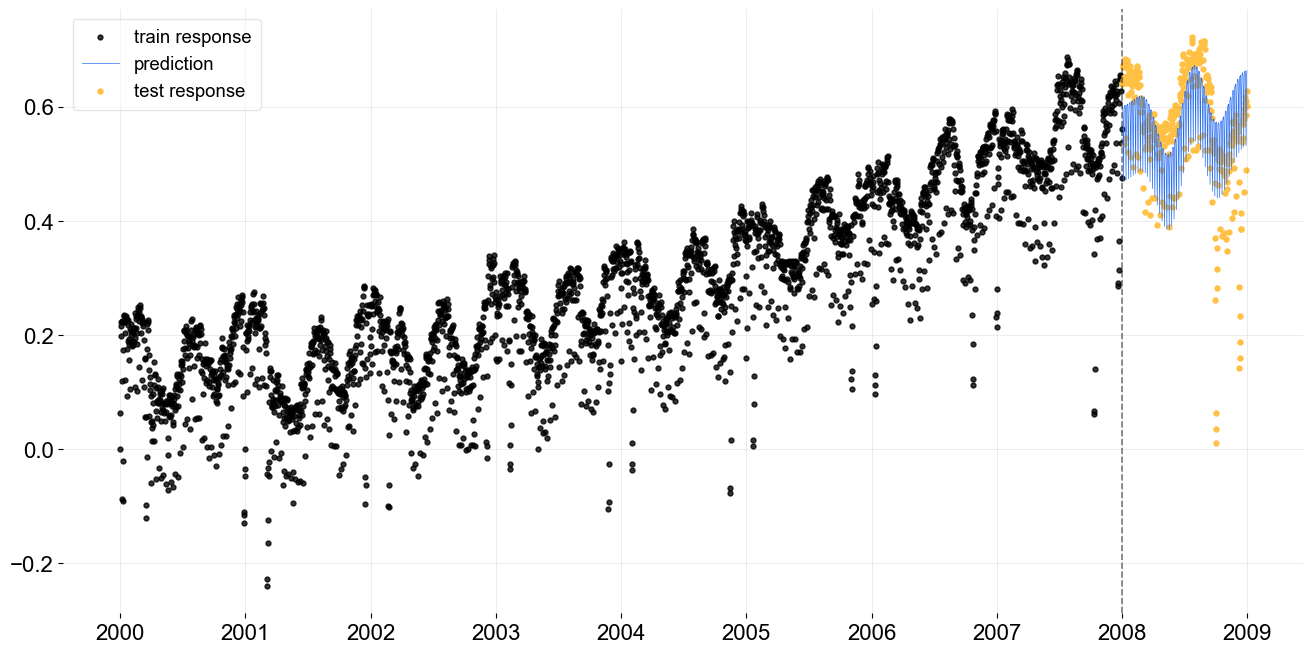

In [35]:
pred_df = dlt.predict(test_df)
plot_predicted_data(train_df, pred_df, 'date', 'electricity', 'prediction', test_actual_df=test_df, lw=0.5);

## Conclusion

In this article, we provide a work around solution to use **DLT** to model data with complex seasonality. One can combine the usage of hyper-parameters tuning to further optimize the smoothing parameters by either backtest or the leave-future-out BICs.  Alternatively, users can consider solution such as **dynamic harmonic regression** or the **KTR(check out other tuturial section in Orbit for details)**.

## References

1. Young, P. C., Pedregal, D. J., & Tych, W. (1999). Dynamic harmonic regression. Journal of Forecasting, 18, 369–394.\[[DOI](https://doi.org/10.1002/(SICI)1099-131X(199911)18:6%3C369::AID-FOR748%3E3.0.CO;2-K)\]